In [2]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.graphics.gofplots as sm
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

results = {}

def score_dataset(x_train, x_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=200, random_state=10)
    model.fit(x_train, y_train)
    preds = model.predict(x_valid)
    return res_score(y_valid, preds)

def plot(data, res, feature):
    fig, axs = plt.subplots(2,2, squeeze=False)
    data['Prediction'] = res.predict(data)
    plt.tight_layout()

    ax = data.plot.scatter(x=feature,y='SalePrice', ax=axs[0,0])
    data.plot(x=feature,y='Prediction', ax=axs[0,0], color='red', style='s')
    # plt.subplot(2,2,2)
    residuals = res.predict(data)-data['SalePrice']
    axs[0,1].scatter(data[feature], (residuals))
    axs[0,1].set_xlabel(feature)
    axs[0,1].set_ylabel('Residual values')

    axs[1,0].hist(residuals)
    axs[1,0].set_ylabel('frequency')
    axs[1,0].set_xlabel('residuual values')
    plt.subplot(2,2,4)
    sm.qqplot(residuals, stats.t, distargs=(4,), loc=3, scale=10, fit=True, ax=axs[1,1], line='s')
    plt.tight_layout()

# Data loader

In [3]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
df_test_y = pd.read_csv('input/sample_submission.csv')

data_test = pd.concat([df_test, df_test_y], axis=1)
data_test = data_test.dropna(subset=['TotalBsmtSF'])

# Check Null values

In [4]:
#missing data for train
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# missing data for test
total_test = data_test.isnull().sum().sort_values(ascending=False)
percent_test = (data_test.isnull().sum()/data_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_data_test.head(20)

,Total,Percent
PoolQC,1455,0.997942
MiscFeature,1407,0.965021
Alley,1351,0.926612
Fence,1169,0.801783
FireplaceQu,729,0.500000
LotFrontage,227,0.155693
GarageYrBlt,78,0.053498
GarageQual,78,0.053498
GarageCond,78,0.053498
GarageFinish,78,0.053498


# Erase Null values

In [5]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, axis=1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

data_test = data_test.drop((missing_data_test[missing_data_test['Total'] > 0]).index, axis=1)
data_test = data_test.drop(data_test.loc[data_test['Electrical'].isnull()].index)
data_test.isnull().sum().max() #just checking that there's no missing data missing...

0

# Outliers erase

### GrLivArea

1129.0
1118.25


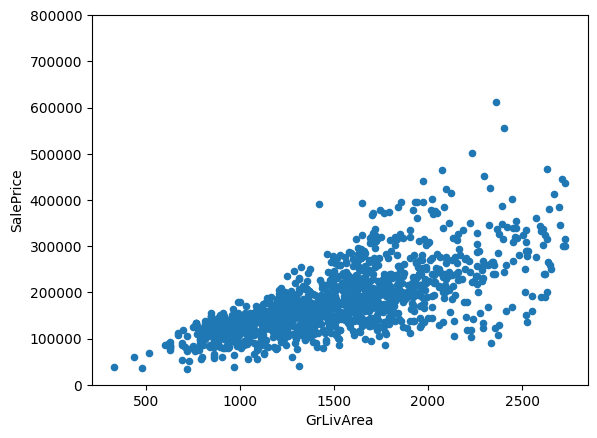

In [6]:
quantiles = df_train.quantile(q=[.25, .75], numeric_only=True)
print(quantiles['GrLivArea'][0.25])

GrLivArea = quantiles['GrLivArea']

df_train = df_train.drop(df_train[(df_train['GrLivArea'] < GrLivArea[0.25] - 1.5*(GrLivArea[0.75] - GrLivArea[0.25])) | (df_train['GrLivArea'] > GrLivArea[0.75] + 1.5*(GrLivArea[0.75] - GrLivArea[0.25]))].index)

df_train.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));


# test data
quantiles_test = data_test.quantile(q=[.25, .75], numeric_only=True)
print(quantiles_test['GrLivArea'][0.25])

GrLivArea = quantiles_test['GrLivArea']

data_test = data_test.drop(data_test[(data_test['GrLivArea'] < GrLivArea[0.25] - 1.5*(GrLivArea[0.75] - GrLivArea[0.25])) | (data_test['GrLivArea'] > GrLivArea[0.75] + 1.5*(GrLivArea[0.75] - GrLivArea[0.25]))].index)

### TotalBsmtSF

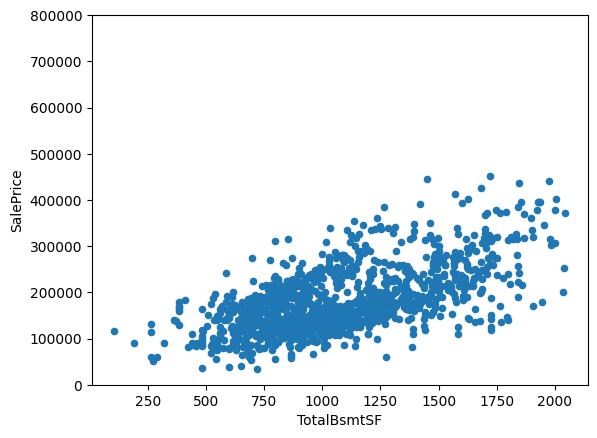

In [7]:
TotalBsmtSF = quantiles['TotalBsmtSF']

df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] < TotalBsmtSF[0.25] - 1.5*(TotalBsmtSF[0.75] - TotalBsmtSF[0.25])) | (df_train['TotalBsmtSF'] > TotalBsmtSF[0.75] + 1.5*(TotalBsmtSF[0.75] - TotalBsmtSF[0.25]))].index)

df_train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

# test data
TotalBsmtSF = quantiles_test['TotalBsmtSF']
data_test = data_test.drop(data_test[(data_test['TotalBsmtSF'] < TotalBsmtSF[0.25] - 1.5*(TotalBsmtSF[0.75] - TotalBsmtSF[0.25])) | (data_test['TotalBsmtSF'] > TotalBsmtSF[0.75] + 1.5*(TotalBsmtSF[0.75] - TotalBsmtSF[0.25]))].index)

### SalePrice

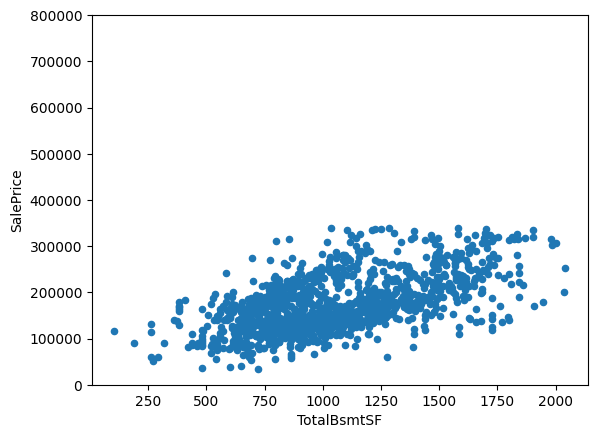

In [8]:
SalePrice = quantiles['SalePrice']

df_train = df_train.drop(df_train[(df_train['SalePrice'] < SalePrice[0.25] - 1.5*(SalePrice[0.75] - SalePrice[0.25])) | (df_train['SalePrice'] > SalePrice[0.75] + 1.5*(SalePrice[0.75] - SalePrice[0.25]))].index)

df_train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

# test data
SalePrice = quantiles_test['SalePrice']

data_test = data_test.drop(data_test[(data_test['SalePrice'] < SalePrice[0.25] - 1.5*(SalePrice[0.75] - SalePrice[0.25])) | (data_test['SalePrice'] > SalePrice[0.75] + 1.5*(SalePrice[0.75] - SalePrice[0.25]))].index)

# Erase not importanta labels from OverallQual

In [9]:
df_train['OverallQual'] = [1 if qual < 7 else qual for qual in df_train['OverallQual']]
data_test['OverallQual'] = [1 if qual < 7 else qual for qual in data_test['OverallQual']]

# Forest tree

In [10]:
data_y = df_train['SalePrice']
data_x = df_train.drop(columns='SalePrice')[['GrLivArea', 'OverallQual', 'TotalBsmtSF']]

data_test_x = data_test[['GrLivArea', 'OverallQual', 'TotalBsmtSF']]
data_test_y = data_test['SalePrice']

regression = pd.concat([data_x, data_y], axis=1)


score = score_dataset(data_x, data_test_x, data_y, data_test_y)

results['ForestTree'] = score

# Model relation between SalePrice and GrLivArea

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     1227.
Date:                Wed, 20 Dec 2023   Prob (F-statistic):          3.27e-191
Time:                        00:12:00   Log-Likelihood:                -16141.
No. Observations:                1338   AIC:                         3.229e+04
Df Residuals:                    1336   BIC:                         3.230e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.502e+04   4039.348      8.669      0.0

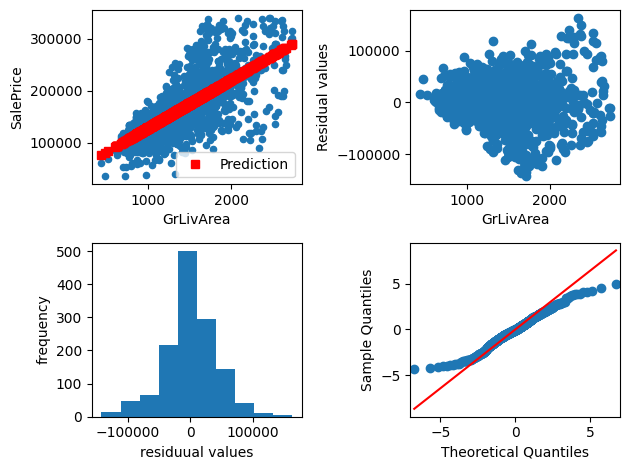

In [11]:
model1 = ols('SalePrice ~ GrLivArea', data=regression)
res1 = model1.fit()
print(res1.summary())
plot(df_train, res1, 'GrLivArea')

res1_predict = res1.predict(data_test_x)
score = r2_score(data_test_y, res1_predict)

results['GrLivArea'] = score

# Model relation between SalePrice and OverallQual

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     424.1
Date:                Wed, 20 Dec 2023   Prob (F-statistic):          8.70e-236
Time:                        00:12:01   Log-Likelihood:                -16028.
No. Observations:                1338   AIC:                         3.207e+04
Df Residuals:                    1333   BIC:                         3.209e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.415e+05 

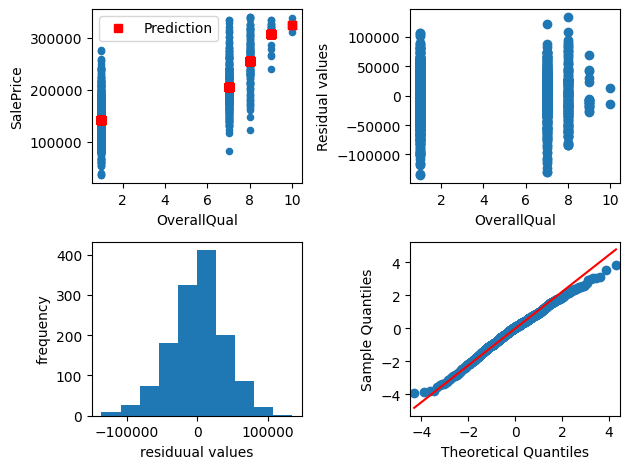

In [12]:
model2 = ols('SalePrice ~ C(OverallQual)', data=regression)
res2 = model2.fit()
print(res2.summary())
plot(df_train, res2, 'OverallQual')

res2_predict = res2.predict(data_test_x)
score = r2_score(data_test_y, res2_predict)

results['C(OverallQual)'] = score

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     703.2
Date:                Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:12:01   Log-Likelihood:                -15622.
No. Observations:                1338   AIC:                         3.126e+04
Df Residuals:                    1331   BIC:                         3.129e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.829e+04 

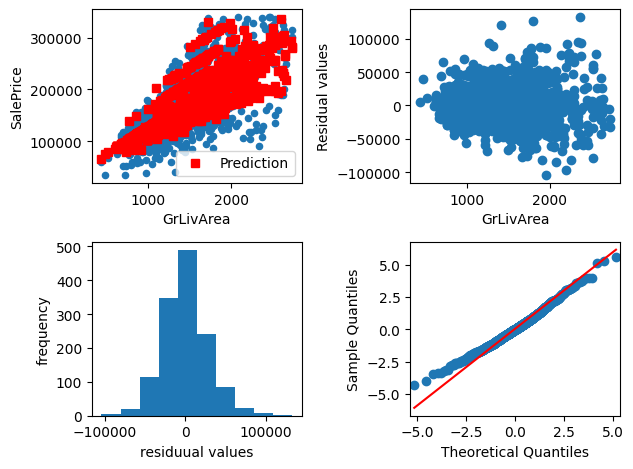

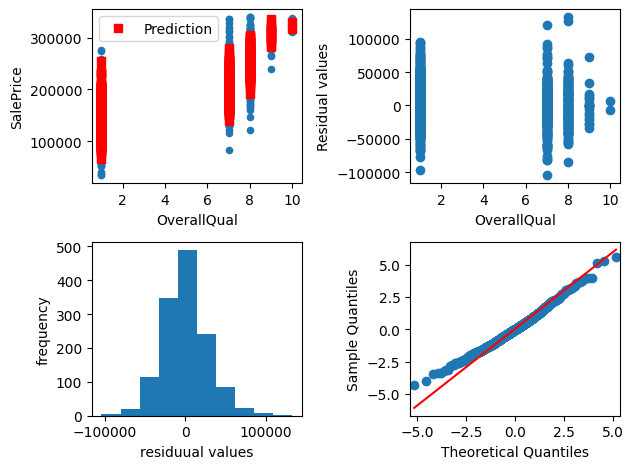

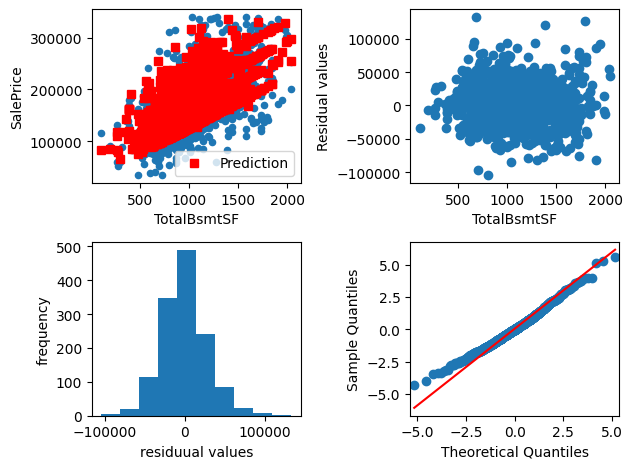

In [13]:
model_combined = ols('SalePrice ~ GrLivArea + C(OverallQual) + TotalBsmtSF', data=regression)
res_combined = model_combined.fit()
print(res_combined.summary())
plot(df_train, res_combined, 'GrLivArea')
plot(df_train, res_combined, 'OverallQual')
plot(df_train, res_combined, 'TotalBsmtSF')

res_combined_predict = res_combined.predict(data_test_x)
score = r2_score(data_test_y, res_combined_predict)

results['GrLivArea + C(OverallQual) + TotalBsmtSF'] = score

In [14]:
for key in results:
    print(f'{key}: {results[key]}')
max_value = max(results, key=results.get)
print(f'Best value:\n Type: {max_value}\n Value: {results[max_value]}')

ForestTree: -15.536230646766498
GrLivArea: -5.42938395875441
C(OverallQual): -13.091568114692665
GrLivArea + C(OverallQual) + TotalBsmtSF: -14.769723059615353
Best value:
 Type: GrLivArea
 Value: -5.42938395875441
